In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from sklearn.utils import resample

%matplotlib inline

# ECS7024 Statistics for Artificial Intelligence and Data Science

## Coursework 4

This notebook will further analyse data used by Matthews (2000) which has data on 17 countries including area, population, birth rate, number of storks in the area and percentage of the area suitable for storks. More specifically it will firstly compare two regression models to explain the variability in the number of births and secondly it will compare the performance of two regression models to predict the number of storks.



**Table of Contents**


 1. Section 1: Data Preperation
     1. Introducing the Data Set
     1. Deriving Additional Variables

&NewLine;

 2. Section 2: Variability in the Number of Births
     1. Regression Model 1: Storks Predictor
     1. Regression Model 2: Population Size Predictor
     1. Bootstrap: Estimate Distribution of the Difference in the R2 parameter.

&NewLine;

 3. Section 3: Predicting the Number of Storks
     1. Regression Model 1: Land Area Predictor
     1. Regression Model 2: Suitable Area and Population Density Predictors
     1. Bootstrap: Estimate Distribution of the Difference in the RMSE parameter.
     1. Conclusion

&NewLine;

 4. Section 4: References




## Section 1: Data Preperation

### 1. A. Introducing the Data Set



Below the data has been loaded into a data frame 'Storks'.

In [2]:
Storks = pd.read_csv('storks.csv')
Storks

,Country,Area,Storks,Humans,BirthRate,SuitableAreaPercent
0,Albania,28750,100,3.2,83,55.68
1,Austria,83860,300,7.6,87,38.34
2,Belgium,30520,1,9.9,118,65.93
3,Bulgaria,111000,5000,9.0,117,57.99
4,Denmark,43100,9,5.1,59,81.46
5,France,544000,140,56.0,774,58.47
6,Germany,357000,3300,78.0,901,59.81
7,Greece,132000,2500,10.0,106,47.31
8,Holland,41900,4,15.0,188,70.96
9,Hungary,93000,5000,11.0,124,75.86


### 1. B. Deriving Additional Variables

For the analysis the variables need to be in terms of consistent units for them to be comparable.

* In the original data the 'Humans' value is $* 10^6$, therefore for a true population of people in each country, for every row the 'Humans' value is multiplied by 1000000 and added to a new column 'PopulationSize'.

* This analysis will also require a population density value. To derive this, in every row the 'PopulationSize' value is divided by the 'Area' value and added to a new column 'PopulationDensity' which shows population per square Km.

* In the original data the 'BirthRate' value is $ * 10^3$, therefore for a true birth rate per year for each country, for every row the 'BirthRate' value is multiplied by 1000 and added to a new column 'BirthRateActual'.

* In the data, suitable area is given as a percentage. For it to be consistent with the other data it needs to be in square Km. This can be done by dividing 'SuitableAreaPercent' for each row by 100 and then multiplying this value by that row's 'Area' value. This value is then added to a new column 'SuitableArea'.

The resulting data frame can be viewed below in a new data frame 'Storks2'.

In [3]:
Storks = pd.read_csv('storks.csv')
Storks2 = Storks.assign(PopulationSize = Storks.Humans * 1000000)
Storks2 = Storks2.assign(PopulationDensity = Storks2.PopulationSize / Storks2.Area)
Storks2 = Storks2.assign(BirthRateActual = Storks2.BirthRate * 1000)
Storks2 = Storks2.assign(SuitableArea = Storks2.SuitableAreaPercent/100 * Storks2.Area)
Storks2

,Country,Area,Storks,Humans,BirthRate,SuitableAreaPercent,PopulationSize,PopulationDensity,BirthRateActual,SuitableArea
0,Albania,28750,100,3.2,83,55.68,3200000.0,111.304348,83000,16008.000
1,Austria,83860,300,7.6,87,38.34,7600000.0,90.627236,87000,32151.924
2,Belgium,30520,1,9.9,118,65.93,9900000.0,324.377457,118000,20121.836
3,Bulgaria,111000,5000,9.0,117,57.99,9000000.0,81.081081,117000,64368.900
4,Denmark,43100,9,5.1,59,81.46,5100000.0,118.329466,59000,35109.260
5,France,544000,140,56.0,774,58.47,56000000.0,102.941176,774000,318076.800
6,Germany,357000,3300,78.0,901,59.81,78000000.0,218.487395,901000,213521.700
7,Greece,132000,2500,10.0,106,47.31,10000000.0,75.757576,106000,62449.200
8,Holland,41900,4,15.0,188,70.96,15000000.0,357.995227,188000,29732.240
9,Hungary,93000,5000,11.0,124,75.86,11000000.0,118.279570,124000,70549.800


## Section 2: Variability in the Number of Births

This section will compare two regression models to explain the variability of the number of births.

The predictor of the first model will be pairs of storks and the predictor for the second model will be population size, with the outcome variable for both as birth rate.

For a regression analysis to work well, the outcome variable is assumed to be normally distributed, therefore before continuing it is important to view the distribution of the new BirthRateActual variable as this will be the outcome variable. This distribution can be viewed below.

Text(0.5, 1.0, 'Birth Rate Distribution')

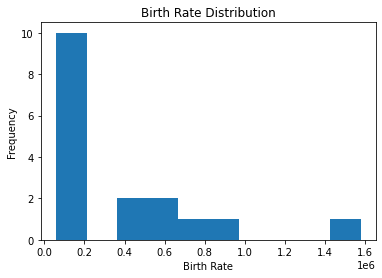

In [4]:
BirthRateDist = Storks2.loc[:, 'BirthRateActual']
fig, at = plt.subplots(1, 1)
at.hist(BirthRateDist, bins=10, density=False)
_ = at.set_xlabel('Birth Rate')
_ = at.set_ylabel('Frequency')
at.set_title('Birth Rate Distribution')

The histogram shows that the Birth Rate distribution is positively skewed. This should be kept in mind when interpreting the results.

### 2. A. Regression Model 1: Storks Predictor

A regression line for the first model is fitted with pairs of storks as the predictor variable and birth rate as the outcome variable. The R2 coefficient, the intercept and the estimated regression coefficient are reported below.

In [5]:
y = Storks2.BirthRateActual
X = np.column_stack(Storks2.Storks)
X = X.reshape(-1, 1)
reg = LinearRegression().fit(X, y)

print('The R2 coefficient of determination is %4.3f' % reg.score(X, y))
beta_Storks = reg.coef_

print('The intercept is %4.1f' % reg.intercept_)

print('Estimated regression coefficient for Storks is %4.2f' % beta_Storks, 
      'difference in birth rate rating per pair of storks.')

The R2 coefficient of determination is 0.385
The intercept is 225028.7
Estimated regression coefficient for Storks is 28.79 difference in birth rate rating per pair of storks.


The important metric for this analysis is the R2 coefficient of each model as this is what tells us how much of the variance in birth rates can be explained by the predictor variable. In this case 38.5% of the variance in birth rates can be explained by the number of pairs of storks.

The regression model can be visualised in the scatter plot below.

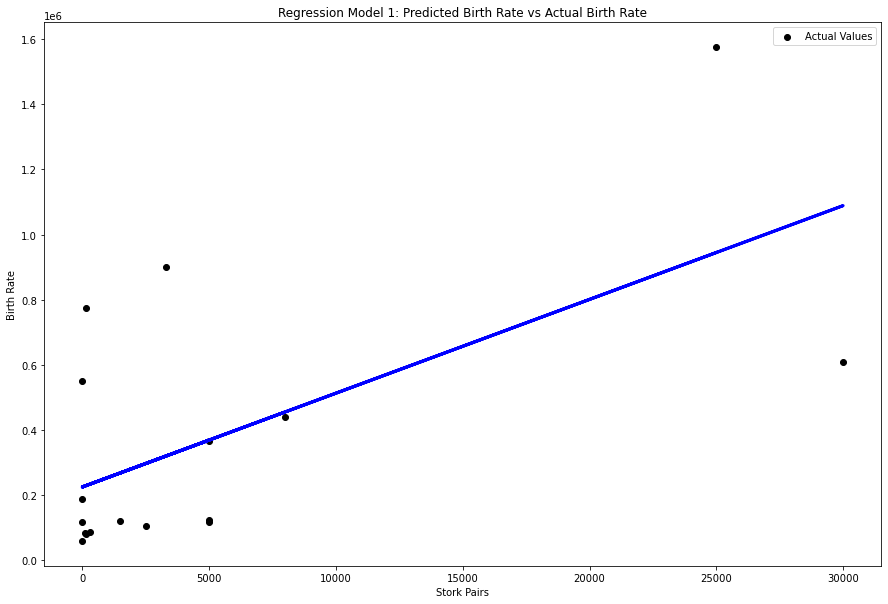

In [6]:
y_hat = reg.predict(X)
fig, a = plt.subplots(1,1,figsize=(15,10))
actual_values = a.scatter(X, y,  color='black')
a.plot(X, y_hat, color='blue', linewidth=3, label = 'Predicted Values')

a.set_xlabel('Stork Pairs')
a.set_ylabel('Birth Rate')
a.set_title('Regression Model 1: Predicted Birth Rate vs Actual Birth Rate')
a.legend([actual_values], ['Actual Values'])

### 2. B. Regression Model 2: Population Size Predictor

A regression line for the second model is fitted with population size as the predictor variable and birth rate as the outcome variable. The R2 coefficient, the intercept and the estimated regression coefficient are reported below.

In [7]:
y = Storks2.BirthRateActual
X2 = np.column_stack(Storks2.PopulationSize)
X2 = X2.reshape(-1, 1)
reg = LinearRegression().fit(X2, y)

print('The R2 coefficient of determination is %4.3f' % reg.score(X2, y))
beta_PopSize = reg.coef_

print('The intercept is %4.1f' % reg.intercept_)

print('Estimated regression coefficient for population size is %4.2f' % beta_PopSize, 
      'difference in birth rate rating per person.')

The R2 coefficient of determination is 0.725
The intercept is -8445.1
Estimated regression coefficient for population size is 0.01 difference in birth rate rating per person.


In this case 72.5% of the variance in birth rates can be explained by number of population size.

The regression model can be visualised in the scatter plot below.

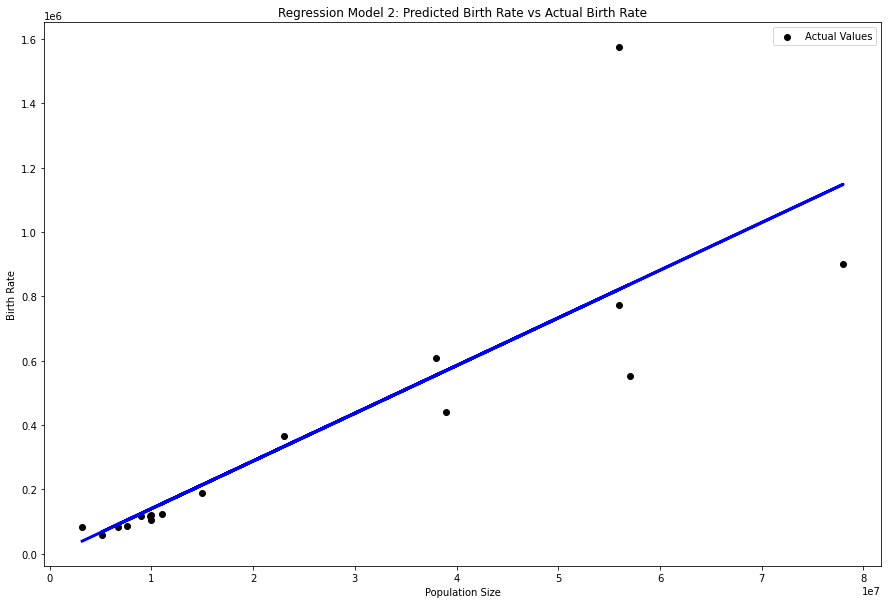

In [8]:
y_hat2 = reg.predict(X2)
fig, a = plt.subplots(1,1,figsize=(15,10))
actual_values = a.scatter(X2, y,  color='black')
a.plot(X2, y_hat2, color='blue', linewidth=3)

a.set_xlabel('Population Size')
a.set_ylabel('Birth Rate')
a.set_title('Regression Model 2: Predicted Birth Rate vs Actual Birth Rate')
a.legend([actual_values], ['Actual Values'])

* When comparing both of these models it seems clear from both the R2 coefficients and the scatter plots that model 2 with population size as the predictors fits better than model 1 with pairs of storks as the predictor.

* This can be seen in the scatter plots as the actual values are visibly closer to the regression line for model 2 than they are for model 1.

* There is also a difference in the R2 value with the model 2 R2 value being 0.34 bigger than the model 1 R2 value, suggesting that using population size as a predictor creates a better model than using number of pairs of storks as a predictor.

* However, to have confidence that the R2 of model 2 is consistently higher than the R2 of model 1, this analysis would need to be done with several different samples. As we don't have access to such samples a bootstrap technique can be used to estimate the distribution of the difference in the R2 parameter between model 1 and model 2, and determine a confidence interval.

### 2. C. Bootstrap: Estimate Distribution of the Difference in the R2 parameter.

First a bootstrap function is defined with parameters 'data' (the data set being used), 'cols' (the column names in the output data frame), 'repeats' (how many times the process is run), and 'func' (the function that will be carried out on the samples). The function then resamples the data however many times specified and then the function is carried out on each sample.

In [9]:
def bootstrapC(data, cols, repeats, func):
    result = pd.DataFrame(data = dict([(c, np.empty(repeats)) for c in cols]))
    
    for i in range(0, repeats):
        result.iloc[i] = func(resample(data))
    return result

Now the bootstrap method is carried out with the data being resampled 500 times and the function fitting each regression model created earlier to every sample. The output data frame has two columns 'Reg_Score' and 'Reg2_score', containing the R2 scores of model 1 and model 2 (respectively) for each sample. A third column is then added 'R2_diff' which is calculated by subtracting 'Reg_Score' from 'Reg2_score' for each row.

The data frame can be seen below.

In [10]:
def doRegressionR2(df) :
    y = df.BirthRateActual
    X = df.Storks
    X = X.to_numpy(dtype=None, copy=False)
    X = X.reshape(-1, 1)
    X2 = df.PopulationSize
    X2 = X2.to_numpy(dtype=None, copy=False)
    X2 = X2.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    reg2 = LinearRegression().fit(X2, y)
    return [reg.score(X, y), reg2.score(X2, y)] 

bstrap = bootstrapC(Storks2, ['Reg_Score', 'Reg2_Score'], 500, doRegressionR2)
bstrap = bstrap.assign(R2_diff = bstrap.Reg2_Score - bstrap.Reg_Score)
bstrap

,Reg_Score,Reg2_Score,R2_diff
0,0.440460,0.739171,0.298711
1,0.488441,0.623171,0.134730
2,0.373397,0.670259,0.296862
3,0.629283,0.763657,0.134374
4,0.371354,0.761334,0.389980
...,...,...,...
495,0.386563,0.656492,0.269929
496,0.287553,0.896923,0.609370
497,0.693505,0.742213,0.048708
498,0.585968,0.721463,0.135495


Now the distribution of each column can be viewed as a histogram below.

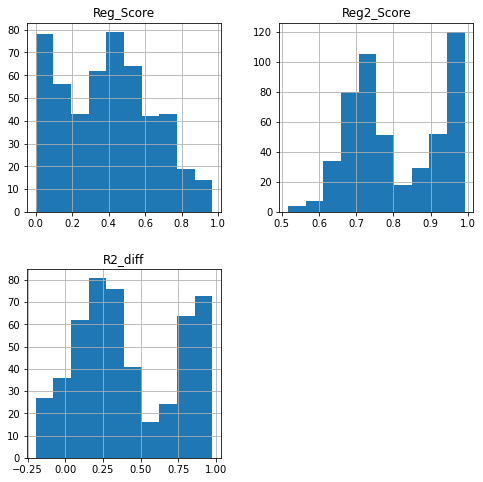

In [11]:
_ = bstrap.hist(figsize=(8,8))


Now that we have a distribution of the difference in R2 scores of each model, a 90% confidence interval can be taken to determine whether the difference between R2 of model 1 and R2 of model 2 is significant.

In [12]:
print("The range of a 90%% CI for the difference in R2 is from %3.2f to %3.2f" % 
      (bstrap.R2_diff.quantile(0.05), bstrap.R2_diff.quantile(0.95)))

The range of a 90% CI for the difference in R2 is from -0.08 to 0.95


As 0 falls within the range of the 90% confidence interval, using this threshold we can not be confident that the R2 of model 2 is higher than the R2 of model 1, meaning that we can not say for sure which model explains more of the variability in the number of births.

## Section 3: Predicting the Number of Storks

This section will compare the performance of two regression models to predict the number of storks.

The predictor of the first model will be land area and for the second model there will be two predictors, population density and the area of suitable land. Both models will have the outcome variable as number of storks.

For a regression analysis to work well, the outcome variable is assumed to be normally distributed, therefore before continuing it is important to view the distribution of the 'Storks' variable as this will be the outcome variable. This distribution can be viewed below.

Text(0.5, 1.0, 'Number of Pairs of Storks Distribution')

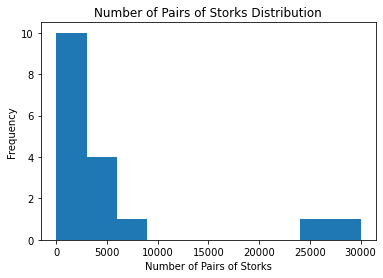

In [13]:
StorkDist = Storks2.loc[:, 'Storks']
fig, at = plt.subplots(1, 1)
at.hist(StorkDist, bins=10, density=False)
_ = at.set_xlabel('Number of Pairs of Storks')
_ = at.set_ylabel('Frequency')
at.set_title('Number of Pairs of Storks Distribution')

The histogram shows that the Number of Pairs of Storks distribution is positively skewed. This should be kept in mind when interpreting the results.

### 3. A. Regression Model 1: Land Area Predictor

A regression line for the first model is fitted with land area as the predictor variable and number of pairs of storks as the outcome variable. The R2 coefficient, the intercept and the estimated regression coefficient are reported below.

In [14]:
y = Storks2.Storks
X = np.column_stack(Storks2.Area)
X = X.reshape(-1, 1)
reg = LinearRegression().fit(X, y)

print('The R2 coefficient of determination is %4.3f' % reg.score(X, y))
beta_Area = reg.coef_

print('The intercept is %4.1f' % reg.intercept_)

print('Estimated regression coefficient for Land Area Predictor is %4.2f' % beta_Area, 
      'difference in number of pairs of storks per square km.')

The R2 coefficient of determination is 0.336
The intercept is -60.7
Estimated regression coefficient for Land Area Predictor is 0.02 difference in number of pairs of storks per square km.


As this analysis is specifically looking at the performance of these two models it is important to take the error into consideration when evaluating the performance of the models. Below is the distribution of the errors between the predicted and actual number of storks.

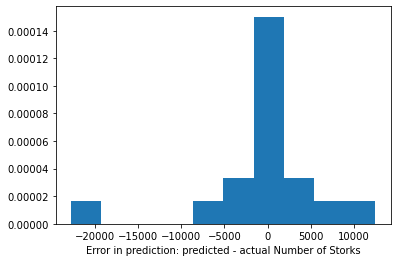

In [15]:
y_hat = reg.predict(X)

fig, a1 = plt.subplots(1, 1)
residuals = y_hat - y
a1.hist(residuals, bins=10, density=True)
_ = a1.set_xlabel('Error in prediction: predicted - actual Number of Storks')

Here we see that the range of errors is approximately normal. From this the regression model can be visualised in the scatter plot below.

Text(0, 0.5, 'Actual Value')

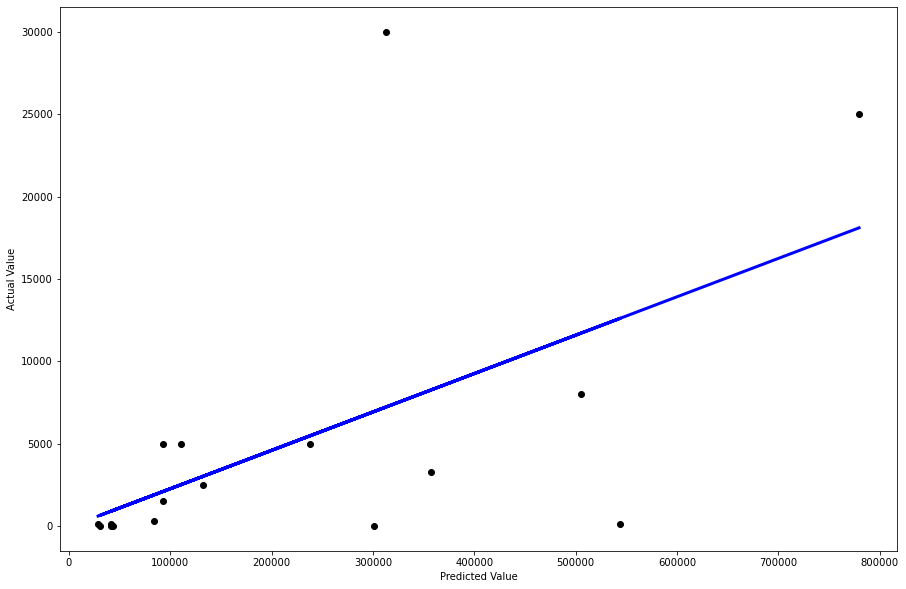

In [16]:
# Plot outputs
fig, a = plt.subplots(1,1,figsize=(15,10))
a.scatter(X, y,  color='black')
a.plot(X, y_hat, color='blue', linewidth=3)

# two_std = residuals.std() * 2
# a.errorbar(y_hat, y, yerr=two_std, fmt='.k')

a.set_xlabel('Predicted Value')
a.set_ylabel('Actual Value')

Now the root of the mean squared error can be calculated.

In [17]:
print('Root of the mean squared error: %.2f'% mean_squared_error(y, y_hat, squared=False))

Root of the mean squared error: 6984.77


### 3. B. Regression Model 2: Suitable Area and Population Density Predictors

A regression line for the second model is fitted with suitable area and population density as predictor variables and number of pairs of storks as the outcome variable. The R2 coefficient, the intercept and the estimated regression coefficient are reported below.

In [18]:
y = Storks2.Storks
X2 = np.column_stack((Storks2.SuitableArea, Storks2.PopulationDensity))
reg = LinearRegression().fit(X2, y)


print('The R2 coefficient of determination is %4.3f' % reg.score(X2, y))
beta_SuitableArea,  beta_Humans = reg.coef_

print('The intercept is %4.1f' % reg.intercept_)

print('Estimated regression coefficient for SuitableArea is %4.2f' % beta_SuitableArea, 
      'difference in number of pairs of storks per square km.')

print('Estimated regression coefficient for population dnesity is %4.2f' % beta_Humans, 
      'difference in number of pairs of storks per person per square km.')

The R2 coefficient of determination is 0.393
The intercept is 1881.4
Estimated regression coefficient for SuitableArea is 0.04 difference in number of pairs of storks per square km.
Estimated regression coefficient for population dnesity is -12.13 difference in number of pairs of storks per person per square km.


Below is the distribution of the errors between the predicted and actual number of storks.

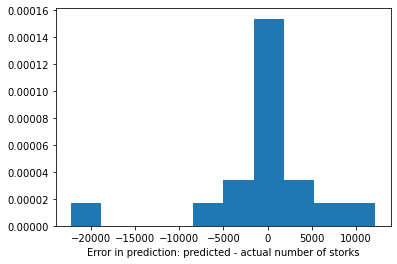

In [19]:
y_hat = reg.predict(X2)

fig, a1 = plt.subplots(1, 1)
residuals = y_hat - y
a1.hist(residuals, bins=10, density=True)
_ = a1.set_xlabel('Error in prediction: predicted - actual number of storks')

Here we see that the range of errors is approximately normal. From this the regression model can be visualised in the scatter plot below.

Text(0, 0.5, 'Actual Value')

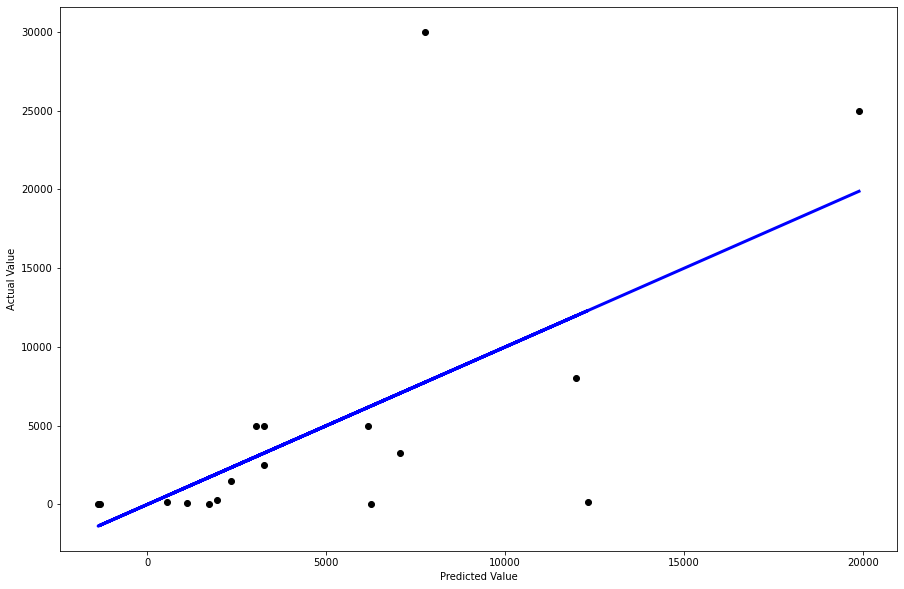

In [20]:
# Plot outputs
fig, a = plt.subplots(1,1,figsize=(15,10))
a.scatter(y_hat, y,  color='black')
a.plot(y_hat, y_hat, color='blue', linewidth=3)

# two_std = residuals.std() * 2
# a.errorbar(y_hat, y, yerr=two_std, fmt='.k')

a.set_xlabel('Predicted Value')
a.set_ylabel('Actual Value')

Now the root of the mean squared error can be calculated,

In [21]:
print('Root of the mean squared error: %.2f'% mean_squared_error(y, y_hat, squared=False))

Root of the mean squared error: 6677.03


Now that we have calculated the RMSE (root of the mean squared error) for both models, these metrics can be compared.

* Model 1 has an RMSE of 6984.77, while model 2 has an RMSE of 6677.03. This suggests that as the mean error is lower for model 2 than model 1, the performance of the regression model 2 is better than that of the regression model 1 at predicting the number of storks.

* This suggests that 'Suitable Area' and 'Population Density' are better predictors than 'Land Area'.

* However, to have confidence in this result this analysis would need to be done with several different samples. As we don't have access to such samples a bootstrap technique can be used to estimate the distribution of the difference in the RMSE parameter between model 1 and model 2, and determine a confidence interval.

### 3. C. Bootstrap: Estimate Distribution of the Difference in the RMSE parameter.

As a bootstrap function has already been defined, this function can be used to resample, execute a function and create a data frame of the results. However, a new function is defined to return the RMSE value of both models for each sample. These values can be seen in the data frame produced with the column 'RMSE' containing the RMSE values for model 1 and RMSE_2 containing the RMSE values for model 2. A final column RMSE_Diff shows the difference in the RMSE values for each sample. This is calculated by subtracting RMSE2 from RMSE. This data frame can be seen below.


In [22]:
def doRegressionRMSE(df) :
    y = df.Storks
    X = np.column_stack(df.Area)
    X = X.reshape(-1, 1)
    X2 = np.column_stack((df.SuitableArea, df.PopulationDensity))
    reg2 = LinearRegression().fit(X2, y)
    reg = LinearRegression().fit(X, y)
    y_hat = reg.predict(X)
    y_hat2 = reg2.predict(X2)
    return [mean_squared_error(y, y_hat, squared=False), mean_squared_error(y, y_hat2, squared=False)]

bstrap = bootstrapC(Storks2, ['RMSE', 'RMSE2'], 500, doRegressionRMSE)
bstrap = bstrap.assign(RMSE_Diff = bstrap.RMSE - bstrap.RMSE2)
bstrap

,RMSE,RMSE2,RMSE_Diff
0,6022.829049,5810.741852,212.087197
1,6274.789303,5985.767851,289.021452
2,2328.854969,2081.438814,247.416155
3,8072.547091,7760.813989,311.733102
4,2913.211336,2408.027779,505.183557
...,...,...,...
495,6785.426945,6516.012821,269.414124
496,5901.815628,5414.182361,487.633267
497,8728.761274,8460.639324,268.121950
498,8662.358215,8284.654587,377.703629


Now the distributions of the RMSE, RMSE2, and RMSE_Diff are created and can be seen below.

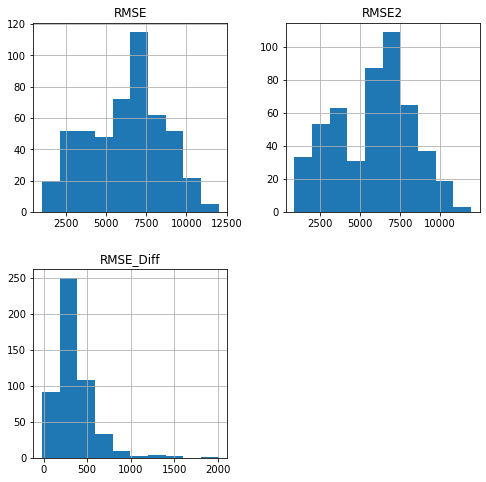

In [23]:
_ = bstrap.hist(figsize=(8,8))

A 90% confidence interval of the difference in the RMSE between the two models can now be taken.

In [24]:
print("The range of a 90%% CI for the difference in RMSE is from %3.2f to %3.2f" % 
      (bstrap.RMSE_Diff.quantile(0.05), bstrap.RMSE_Diff.quantile(0.95)))

The range of a 90% CI for the difference in RMSE is from 108.19 to 699.65


As 0 does not fall within the range of the 90% confidence interval, using this threshold we can be confident that the RMSE of model 2 is lower than the RMSE of model 1, meaning that we can confidently say that the performance of the regression model 2 is better than that of the regression model 1 at predicting the number of storks. This tells us that 'Suitable Area' and 'Population Density' are better predictors of the number of storks than 'Land Area'.

### 3. D. Conclusion

* With a 90% confidence interval we can not be confident that the R2 of model 2 is higher than the R2 of model 1, meaning that we can not say for sure which model explains more of the variability in the number of births.

* With a 90% confidence interval we can be confident that the RMSE of model 2 is lower than the RMSE of model 1, meaning that we can confidently say that the performance of the regression model 2 is better than that of the regression model 1 at predicting the number of storks. This tells us that 'Suitable Area' and 'Population Density' are better predictors of the number of storks than 'Land Area'.

### Section 4: References

Robert Matthews. “Storks Deliver Babies (p = 0.008)”. Teaching Statistics. Volume 22, Number 2, Summer 2000, p36-8.